# Simple NN Automatic differentiation AutoGrad with Computational graphs

So, the derivatives in the last example were pretty painful, and I don't want to do that again. Thankfully, there are some ways to calculate these derivatives that are much more computationally friendly. The method involves using computational graphs and working with some observed characteristics. 

Resources used for this notebook: https://www.youtube.com/watch?v=jS-0aAamC64, Youtube, ArchQuant; Automatic Differentiation Explained with Example



I originally expected us to use numerical approximations to find these gradients, since they are normally used to cut corners in maths wherever speed is key. However, I was wrong. Using common numerical methods (for example finite difference with the taylor series) intoduces truncation error, and for finite difference, the complexity grows linearly with the input dimension $n$, which is not a desired characteristic. 

This means that we want to use a non-numerical exact method. We're going to use symbolic differentiation (i.e. classroom differentation), and we can do this algorithmically with the help of computational graphs.

## Computational graphs

Every neural network can be represented by a computational graph which consists of nodes and connections between each node.
We simplify and expand this graph even more until we get individual operations at each node (addition multiplications etc.) as you can see below 

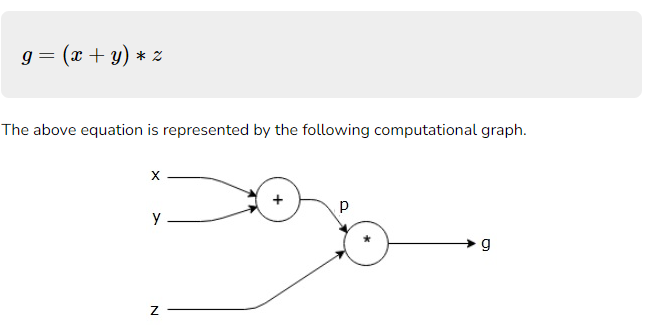

credit: https://www.tutorialspoint.com/python_deep_learning/python_deep_learning_computational_graphs.htm


Thankfully, the operations in neural networks are, at a base level, quite simple. Biases are additions, weights are multiplications (and activation functions can be left till later for now). If we extend this, you should hopefully be able to see how computational graphs can be used to represent how neural networks function.(with these funky line graphs)

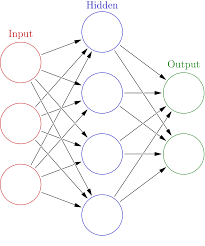

credit: wikipedia https://en.wikipedia.org/wiki/Artificial_neural_network

## Automatic differentiation

So when it comes to finding the derivative of a given weight or bias with the help of computational graphs we have two options. One is called the forward (tangent) mode, and one is called the reverse (adjoint or AAD (adjoint auto-diff)) mode. 

### Forward mode

The forward mode can seem more intuitive. It involves finding the the partial derivatives of each and every state in the neural network with respect to our desired variable.

I.e. if we want to find $\frac{\partial p}{\partial x}$ where p is our loss function (output), then we find  $\dot A_i = \frac{\partial A}{\partial x}$ where $\{A_i: i\in I \}$ is the set of all the states in the network, then we work out $\dot p = \frac{\partial p}{\partial x}$ explicitly from it's explicit formula in the neural network.

In this method, the neural network starts at a certain point and then makes it's way forward until it reaches the end of the graph (at the output) from which it can compute the original point's partial derivative. This is called a forward pass and it must be done for each point in the network.

This means that if the number of inputs is large, the forward mode can be computationally expensive since the gradients need to be computed individually for each input variable giving it a complexity of $O(n)$ where $n$ is the number of inputs. This makes it less suitable for neural networks where the number of input variables can be significant. So we're going to look for a different method that is efficient when the number of output variables is small compared to the number of input variables. This is where reverse mode comes in


### Reverse mode

As the name suggests, for the reverse (or adjoint) method, we want to go backwards from the loss function and take the adjoint derivative $\bar x = \frac{\partial p}{\partial x}$ of each step in the network until we get to our desired variables. 


<b>Forward Pass</b>: During the forward pass, the input data is propagated through the computational graph of the model. The forward pass involves sequential execution of the operations in the network, resulting in the final output or prediction of the model.

<b>Gradient Initialization</b>: After (or during) the forward pass, the gradients of the model's parameters with respect to a specified loss function need to be computed. Before starting the reverse pass, the gradients are initialized. Typically, the gradient for each parameter is set to zero or some default value.

<b>Reverse Pass</b>: In the reverse pass, the gradient computation starts from the final output and propagates backward through the computational graph. The goal is to calculate the gradients of the loss function with respect to the model's parameters.

<b>Local Gradients</b>: At each step of the reverse pass, the local gradient of the current operation or layer is computed. The local gradient represents the derivative of the operation's output with respect to its inputs (i.e. the nodes in the previous layer). It is calculated based on the specific operation (e.g. addition/multiplication/activation function) and its derivatives.

<b>Chain Rule Application</b>: After computing the local gradient, the chain rule is applied to accumulate gradients throughout the computational graph. By applying the chain rule recursively, the gradients are accumulated and propagated backward through the graph. We'll go into this in more detail in the next section



Reverse mode is particularly efficient when the number of output variables is small compared to the number of input variables. This makes it suitable for neural networks, where the gradients need to be computed with respect to a large number of parameters.




To explain these concepts further and with examples, I strongly recommend this youtube video: https://www.youtube.com/watch?v=jS-0aAamC64.

### How the chain rule is applied

the chain rule $\frac{\partial s}{\partial t} = \frac{\partial s}{\partial x} \frac{\partial x}{\partial t}$ can look a bit mathsy and abstract, but we can actually describe it in a more tangible way throught the use of these graphs. If we take a graph like so:


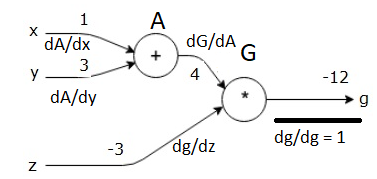

for example, if we want to find the derivative of the state x with respect to the final state g: we need to look at the intermediary states (in this case only p) and look at the local derivatives in the "chain". We'll go backwards and take our first step from $g$ to $p$, the local derivative in this step is $\frac{\partial g}{\partial p}$. Then we take the next step from $p$ to $x$, the local derivative in this step is $\frac{\partial p}{\partial x}$. Now if we multiply these things procedurally, we get $\frac{\partial g}{\partial p} \frac{\partial p}{\partial x} = \frac{\partial g}{\partial x}$ which gives us the desired partial derivative of the state (the one with the loss function with respect to our variable.)


Now, if we consider each of the different states, (in our cases, x, y, z, A and G(g)), we can see that the values of the local derivatives between each of the states is dependent only on the action from the first state to the next and the variable values of the other states in the system. We can work with variables, but now we want to iron out the ideas of how the different oprations influence the local derivatives at each step.

Each operation has it's own simple rule, this is why this graph method is so attractive for computaional means. We'll go through the common operation rules now:

Addition/Subtraction: The gradient with respect to each input (added) is the same as the gradient of the output with respect to that input. So addition conserves the derivative as the same.

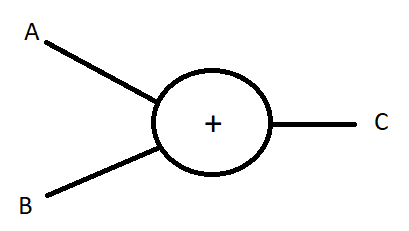

This is because $\frac{\partial g}{\partial L} = \frac{\partial (A + B)}{\partial L}  = \frac{\partial A}{\partial L}  + \frac{\partial B}{\partial L}$ by linearity. so if we set $B$ as constant and vary $A$, then we get that the derivative of $B$ is 0 and  $\frac{\partial g}{\partial L} = \frac{\partial A}{\partial L}$, so the derivative passes as normal. another way of writing this is $\frac{\partial g}{\partial A} = 1$ 

Multiplication/Division: The gradient with respect to each input is the gradient of the output with respect to that input, multiplied by the value of the other input. So multiplication scales the gradient by a factor of the other input.

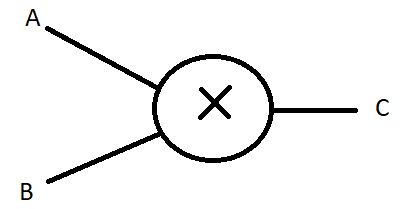

With similar maths as before, $\frac{\partial g}{\partial L} = \frac{\partial (AB)}{\partial L}  = B\frac{\partial A}{\partial L}$ as $B$ is constant. 


Activation Functions: The gradient with respect to the input of an activation function is computed by multiplying the gradient of the output with respect to the activation's output by the derivative of the activation function. Alternitavely, we can break down the activation functions into more operations and calculate how their individual actions in turn. For example:
$$
Softplus(x) = log(1 + e^x) = log(B(A(x)))
$$

where $B(x)  = 1 + x$ and $A(x) = e^x$, 

in this way, we can calculate the derivative effect of each operation in turn:

$\frac{d B}{d x} = 1$,  $\frac{d A}{d x} = e^x$, $\frac{d log(x)}{d x} = \frac{1}{x}$


So with this mathematical intuition for how things are working, we can move onto the implementation of a computational graph in code.

## How this is used in software

In libraries such as pytorch and tensorflow, these algorithms are implemented by creating a system of objects which make up the computaional graph. I'll do an implementation below to show how this works. 

The credit for this section comes from this blog post by rufflewind: https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation, with it's github implementation here: https://github.com/Rufflewind/revad/blob/eb3978b3ccdfa8189f3ff59d1ecee71f51c33fd7/revad.py. In the post, he references the paper by Bartholomew-Biggs et al: https://www.sciencedirect.com/science/article/pii/S0377042700004222?via%3Dihub which has a much more in depth look at automatic differentiation/autograd of algorithms.

This will be somewhat of a shameless copy and paste, but I will try to make it as relevant to our purposes as possible:

So, we want to create a class for variables within the network. These correspond to nodes on the graph.We know this graph flows "to the right." This means that our inputs will essentially be "roots" and also that there won't be any cycles(it's acyclic). 

These two characteristics mean that we can set a finite path backwards from each node(or variable) to these finite number of roots (or inputs.) Hence, we can define our variables to have their values defined by their parents (in the sense of graph theory, this means the nodes who have our variable as one of their children.)

Naturally, we also want our variables to store values and gradient values. So we include this in the object initialisation.

Side note:

We're going to use a coding technique called operator overloading which essentially redefines how an operator (e.g. +,=,\*) works in our code. This is a powerful tool and commonly used in oop. If you're unfamiliar with it, I'd recomment learning about it here(or on your favourite website) before proceeding: https://www.programiz.com/python-programming/operator-overloading.

In the code below, the \_\_init\_\_  corresponds to "=", \_\_add\_\_ to + and  \_\_mul\_\_ to \*. 

### Implementation

We implement our graph with idea of reverse mode strongly in mind. This means that on initialisation, we're going to do a forward pass to calculate the values held by each variable. We only define the values for the roots, then the rest are calculated from our overloaded variables. 

Each time we create a new variable, we append two things to an index in the children array of it's parents. The first being the address of the variable object the second being a float labelled "g_weight". 

The "g_weight" is not our traditional network weight, instead, it is the amount that the gradient of our child affects the gradient of our parent. As we have seen earlier, this depends on the operation that the parents must partake in the create the child (saucy, I know), so it takes that into account. For example, the g_weights for addition are always 1, and the g_weights for multiplication correspond the the value held by the other parent.

When we have created the graph, we then go back recursively to calculate the values of the derivates for each node(variable). To speed this up by avoiding repeat calculations, we also cache the "grad_value" for each Var object, which will allow us to build on previous calculations during our backwards pass.

In [14]:
import math

class Var:
    def __init__(self, value):
        self.value = value
        self.children = []
        # initialize to None, which means it’s not yet evaluated
        self.grad_value = None

    def grad(self):
        # recurse only if the value is not yet cached
        if self.grad_value is None:
            # calculate derivative using chain rule
            self.grad_value = sum(g_weight * var.grad()
                                  for g_weight, var in self.children)
        return self.grad_value

    def __add__(self, other):
        z = Var(self.value + other.value)
        #appends a weight and a var object to the 
        #children array of each parent
        #for addition, the g_weight is always 1
        self.children.append((1.0, z))
        other.children.append((1.0, z))
        return z

    def __mul__(self, other):
        z = Var(self.value * other.value)
        #appends a weight and a var object to the 
        #children array of each parent
        #for multiplication, the g_weight of each parent
        #is the value held by the other parent
        self.children.append((other.value, z))
        other.children.append((self.value, z))
        return z
    
def sin(x):
    z = Var(math.sin(x.value))
    #the weight here is the derivative evaluated at the value of
    #x
    x.children.append((math.cos(x.value), z))
    return z
    
    

[(4.2, <__main__.Var object at 0x000001FD51BE0370>), (0.8775825618903728, <__main__.Var object at 0x000001FD51C6E440>)]


In [29]:
x = Var(2)
y = Var(3)
#z = x * y + sin(x)

z.grad_value = 1.0

print(x.children[1][1].value)

0.9092974268256817


In [21]:
x = Var(0.5)
y = Var(4.2)
z = x * y + sin(x)
z.grad_value = 1.0

assert abs(z.value - 2.579425538604203) <= 1e-15
assert abs(x.grad() - (y.value + math.cos(x.value))) <= 1e-15
assert abs(y.grad() - x.value) <= 1e-15

print(x.children[0][1].grad_value)

1.0


Although this all looks quite impressive, it still isn't great. The memory management is not great, which can cause problems in larger networks. The implementation can be improved in a number clever ways that are above my paygrade for the moment. These can be theory level mathematical optimisations, code specific optimisations or hardware optimisations.

As you may imagine, when the networks get very large, the smallest opitmisation can lead to massive improvements in speed and performance, and due to the current interest in neural nets, this is hot stuff. But for us, this will do. We can delve into the minutia once we understand the basics at a comfortable level of abstraction.